In [1]:
import csv as csv
import numpy as np
import matplotlib as plot
import matplotlib.pyplot as plt
import scipy as sci
import scipy.io as sio
import sklearn as sk
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, average_precision_score, r2_score
from datetime import datetime as dt
import copy
import operator
from scipy.stats import pearsonr
import itertools
import multiprocessing
import json

In [2]:
%matplotlib inline

In [3]:
data_location = "./data/"

In [4]:
all_params = sio.loadmat(data_location + 'PGSE_params.mat')
all_features = sio.loadmat(data_location + 'PGSE_features.mat')
all_features_noise = sio.loadmat(data_location + 'PGSE_features_SNR40.mat')

In [5]:
all_params = all_params['PGSE_params']
all_features = all_features['PGSE_features']
all_features_noise = all_features_noise['PGSE_features_SNR40']

In [6]:
ap = pd.DataFrame(all_params)
af = pd.DataFrame(all_features)
afn = pd.DataFrame(all_features_noise)

In [7]:
ap = pd.DataFrame(all_params)
ap["Volume fraction"] = ap[0]
ap["Exchange time"] = ap[3]
ap["Diffusivity"] = ap[4] * pow(10,9)
del ap[5]
del ap[4]
del ap[3]
del ap[2]
del ap[1]
del ap[0]

In [8]:
print("Volume fraction - min: " + str(ap["Volume fraction"].min()) + " max: " + str(ap["Volume fraction"].max()))
print("Exchange time - min: " + str(ap["Exchange time"].min()) + " max: " + str(ap["Exchange time"].max()))
print("Diffusivity - min: " + str(ap["Diffusivity"].min()) + " max: " + str(ap["Diffusivity"].max()))

Volume fraction - min: 0.40050833378395123 max: 0.7334056524484522
Exchange time - min: 0.021133992104562738 max: 0.9931751365336408
Diffusivity - min: 0.8065463120925068 max: 2.192762268333131


In [9]:
print("Volume fraction range: (0.3,0.7)")
print("Exchange time range: (0,0.9)")
print("Diffusivity range: (0,0.3)")

Volume fraction range: (0.3,0.7)
Exchange time range: (0,0.9)
Diffusivity range: (0,0.3)


In [10]:
train_x, test_x, train_y, test_y = train_test_split(af, ap)

In [11]:
print("Train:")
print(train_x.shape)
print(train_y.shape)
print("")
print("Test:")
print(test_x.shape)
print(test_y.shape)

Train:
(8196, 240)
(8196, 3)

Test:
(2733, 240)
(2733, 3)


Text(0,0.5,'Frequency')

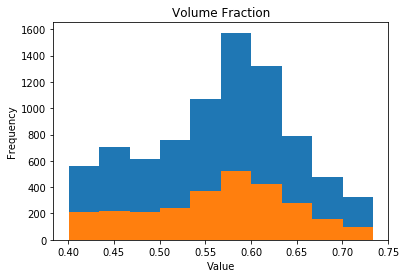

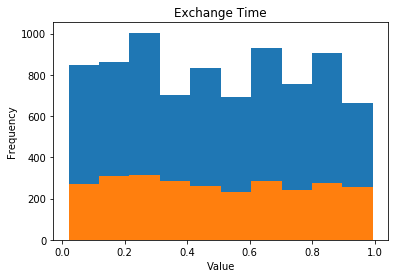

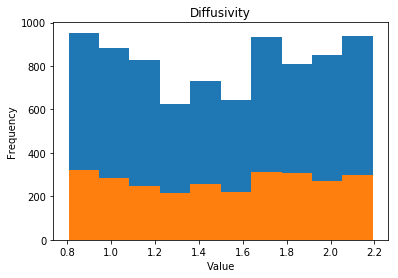

In [12]:
# Volume Fraction
vf = plt.figure()
plt.hist(train_y["Volume fraction"])
plt.hist(test_y["Volume fraction"])
plt.title("Volume Fraction")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Exchange Time
et = plt.figure()
plt.hist(train_y["Exchange time"])
plt.hist(test_y["Exchange time"])
plt.title("Exchange Time")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Diffusivity
d = plt.figure()
plt.hist(train_y["Diffusivity"])
plt.hist(test_y["Diffusivity"])
plt.title("Diffusivity")
plt.xlabel("Value")
plt.ylabel("Frequency")

In [13]:
shells = list(range(0, 16))
shell_c4 = list(itertools.combinations(shells, 4))
shell_c8 = list(itertools.combinations(shells, 8))

In [14]:
def score_regressor(regressor, test_x, test_y):
    test_predictions = regressor.predict(test_x)
    
    vf = pearsonr(test_y["Volume fraction"], list(map(operator.itemgetter(0), test_predictions)))
    et = pearsonr(test_y["Exchange time"], list(map(operator.itemgetter(1), test_predictions)))
    df = pearsonr(test_y["Diffusivity"], list(map(operator.itemgetter(2), test_predictions)))
    
    return (vf, et, df)

In [15]:
def features(shells):
    features = []
    for shell in shells:
        shell *= 15
        for i in range(0,15):
            features += [shell + i]
    return features

def select_shells(data, shells):
    return data.filter(features(shells), axis=1)

In [16]:
def calculate_scores(train_x, train_y, test_x, test_y, shells):
    train_x = select_shells(train_x, shells)
    test_x = select_shells(test_x, shells)
    regressor = RandomForestRegressor(max_depth=40, n_estimators=200, max_features="sqrt")
    regressor.fit(train_x, train_y)
    scores = score_regressor(regressor, test_x, test_y)
    return {"shells":shells, "vf":scores[0], "et":scores[1], "df":scores[2]}

In [17]:
def calculate_scores_partial(shells):
    return calculate_scores(train_x, train_y, test_x, test_y, shells)

In [18]:
scores_c4 = []

with multiprocessing.Pool(8) as p:
    scores_c4 = p.map(calculate_scores_partial, shell_c4)

In [30]:
with open('scores_c4_C.json', 'w') as fp:
    json.dump(scores_c4, fp, sort_keys=True, indent=4)

In [20]:
scores_c8 = []

with multiprocessing.Pool(8) as p:
    scores_c8 = p.map(calculate_scores_partial, shell_c8)

((1, 5, 12, 15), 0.9892503217871562)


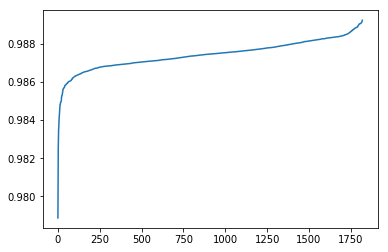

In [31]:
# Volume fraction
vf_scores = []

for score in scores_c4:
    vf_scores += [(score["shells"], score["vf"][0])]
    
vf_scores = sorted(vf_scores, key=operator.itemgetter(1))

plt.plot(list(map(operator.itemgetter(1), vf_scores)))
plt.savefig("vf_clean_4_shells")

print(vf_scores[-1])

((3, 12, 13, 15), 0.7599263593651293)


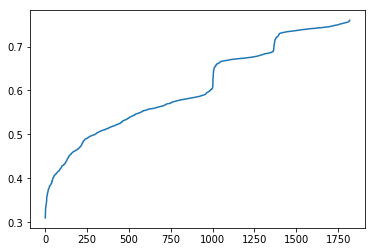

In [32]:
# Exchange time
et_scores = []

for score in scores_c4:
    et_scores += [(score["shells"], score["et"][0])]
    
et_scores = sorted(et_scores, key=operator.itemgetter(1))

plt.plot(list(map(operator.itemgetter(1), et_scores)))
plt.savefig("et_clean_4_shells")

print(et_scores[-1])

((0, 1, 3, 4), 0.9998398765298289)


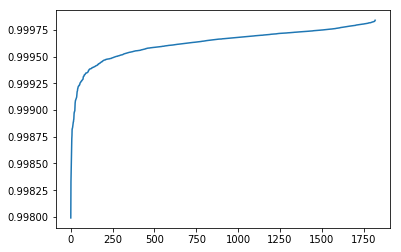

In [33]:
# Diffusivity
df_scores = []

for score in scores_c4:
    df_scores += [(score["shells"], score["df"][0])]
    
df_scores = sorted(df_scores, key=operator.itemgetter(1))

plt.plot(list(map(operator.itemgetter(1), df_scores)))
plt.savefig("df_clean_4_shells")

print(df_scores[-1])

((1, 2, 3, 4, 7, 12, 13, 15), 0.9891423279829907)


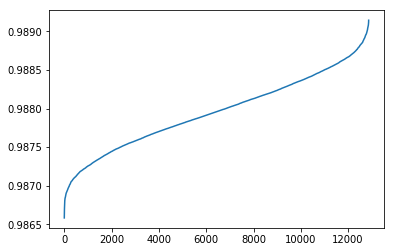

In [34]:
# Volume fraction
vf_scores = []

for score in scores_c8:
    vf_scores += [(score["shells"], score["vf"][0])]
    
vf_scores = sorted(vf_scores, key=operator.itemgetter(1))

plt.plot(list(map(operator.itemgetter(1), vf_scores)))
plt.savefig("vf_clean_8_shells")

print(vf_scores[-1])

((4, 5, 7, 9, 12, 13, 14, 15), 0.7437979342325104)


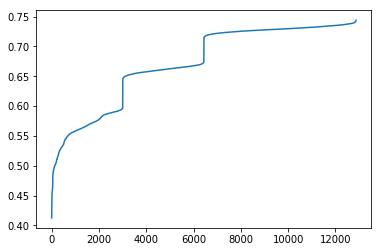

In [35]:
# Exchange time
et_scores = []

for score in scores_c8:
    et_scores += [(score["shells"], score["et"][0])]
    
et_scores = sorted(et_scores, key=operator.itemgetter(1))

plt.plot(list(map(operator.itemgetter(1), et_scores)))
plt.savefig("et_clean_8_shells")

print(et_scores[-1])

((0, 1, 2, 3, 4, 5, 6, 8), 0.9998097817934009)


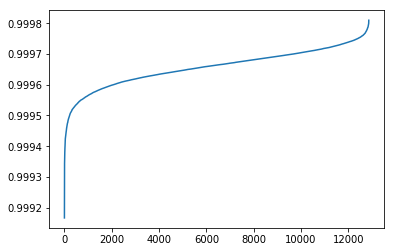

In [36]:
# Diffusivity
df_scores = []

for score in scores_c8:
    df_scores += [(score["shells"], score["df"][0])]
    
df_scores = sorted(df_scores, key=operator.itemgetter(1))

plt.plot(list(map(operator.itemgetter(1), df_scores)))
plt.savefig("df_clean_8_shells")

print(df_scores[-1])

In [37]:
with open('scores_c8_C.json', 'w') as fp:
    json.dump(scores_c8, fp, sort_keys=True, indent=4)